## Tracer on shelf - Diffusivity effects

This notebook explores the effects of changing the diapycnal diffusivity on the total amount of tracers on shelf.

In [1]:
#import gsw as sw # Gibbs seawater package

from math import *

import matplotlib.pyplot as plt

import matplotlib.colors as mcolors

%matplotlib inline

#from MITgcmutils import rdmds

from netCDF4 import Dataset

import numpy as np

import os 

import pandas as pd

import pylab as pl

import scipy.io

import scipy as spy

import seaborn as sns

import sys

In [3]:
lib_path = os.path.abspath('../../Building_canyon/BuildCanyon/PythonModulesMITgcm') # Add absolute path to my python scripts
#lib_path = os.path.abspath('../BuildCanyon/PythonModulesMITgcm') # Add absolute path to my python scripts

sys.path.append(lib_path)

import ReadOutTools_MITgcm as rout 
import MetricsPythonTools as mpt


In [4]:
sns.set()
sns.set_style('darkgrid')
sns.set_context('talk')

In [5]:
#Exp
#CGrid = '/Users/Karina/Research/PhD/Tracers/TemporaryData/BARKLEY/run01/gridGlob.nc' # Smallest volume grid, closed bdy, no canyon.
CGrid = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run03/gridGlob.nc' # Smallest volume grid, closed bdy, no canyon.
CGridOut = Dataset(CGrid)

#CGridNoC = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run07/gridGlob.nc' # Smallest volume grid, closed bdy, no canyon.
#CGridNoCOut = Dataset(CGridNoC)


In [12]:
# General input

nx = 360
ny = 360
nz = 90
nt = 19 # t dimension size 
numTr = 22 # number of tracers in total (CNT =22, 3D = 4, total = 19)

rc = CGridOut.variables['RC']

xc = rout.getField(CGrid, 'XC') # x coords tracer cells
yc = rout.getField(CGrid, 'YC') # y coords tracer cells

drF = CGridOut.variables['drF'] # vertical distance between faces
drC = CGridOut.variables['drC'] # vertical distance between centers
dxF = CGridOut.variables['dxF']
labels = ['Kv_in=1E-7, Kv_out=1E-3','Kv_in=1E-7, Kv_out=1E-4','Kv_in=1E-5, Kv_out=1E-3',
          'Kv_in=1E-5, Kv_out=1E-4','Kv=1E-5','Kv=1E-4','Kv=1E-3','Kv=3.8E-5','Kv=2.8E-5','Kv=1.3E-5',
          'Kv_noc=1E-5','Kv_noc=1E-4','Kv_noc=1E-3','Kv=1E-5','Kv=1E-4','Kv=1E-3','Kv=1E-5','Kv=1E-4','Kv=1E-3',
          'Kv=3.8E-5','Kv=2.8E-5','Kv=1.3E-5']

times = np.arange(0,nt,1)

#print(drC[:])
#print(np.shape(drC))

In [90]:
def get_metrics(exp, run, TrNum, key):
    '''Get column from a tracer metrics pandas dataframe using the key name, run (01, 02, etc) and experiment 
    abreviated name (BAR, CNTDIFF, 3DDIFF, NOGMREDI). All input variables are strings. Returns the desired column from the dataframe'''
    df = pd.read_csv(('results/metricsDataFrames/%srun%sTr%s.csv' %(exp,run,TrNum)))
    col = df[key]
    return col


In [17]:
def get_areas(file, key):
    '''Get column from a tracer metrics pandas dataframe using the key name, run (01, 02, etc) and experiment 
    abreviated name (BAR, CNTDIFF, 3DDIFF, NOGMREDI). All input variables are strings. Returns the desired column from the dataframe'''
    df = pd.read_csv(file)
    col = df[key]
    return col


In [20]:
df = pd.read_csv('results/metricsDataFrames/Canyon_AreasVolumes.csv')

CS1A = get_areas('results/metricsDataFrames/Canyon_AreasVolumes.csv', 'CS1area' )
CS2A = get_areas('results/metricsDataFrames/Canyon_AreasVolumes.csv', 'CS2area' )
CS3A = get_areas('results/metricsDataFrames/Canyon_AreasVolumes.csv', 'CS3area' )
CS3sbA = get_areas('results/metricsDataFrames/Canyon_AreasVolumes.csv', 'CS3sbarea' )
CS4A = get_areas('results/metricsDataFrames/Canyon_AreasVolumes.csv', 'CS4area' )
CS5A = get_areas('results/metricsDataFrames/Canyon_AreasVolumes.csv', 'CS5area' )
AS1A = get_areas('results/metricsDataFrames/Canyon_AreasVolumes.csv', 'AS1area' )
AS2A = get_areas('results/metricsDataFrames/Canyon_AreasVolumes.csv', 'AS2area' )
LID1A = get_areas('results/metricsDataFrames/Canyon_AreasVolumes.csv', 'LID1area' )
LID2A = get_areas('results/metricsDataFrames/Canyon_AreasVolumes.csv', 'LID2area' )
VolHole = get_areas('results/metricsDataFrames/Canyon_AreasVolumes.csv', 'VolHole'  )
VoleShwoHole = get_areas('results/metricsDataFrames/Canyon_AreasVolumes.csv', 'VolShNoHole' )

df

,Unnamed: 0,CS1area,CS2area,CS3area,CS3sbarea,CS4area,CS5area,AS1area,AS2area,LID1area,LID2area,VolHole,VolShNoHole
0,0,3276715.686275,4045784.313725,1941643.205977,2755000,4045784.313725,3185391.812071,973705.821267,972272.840065,40422963.498198,40422963.498198,2.029953e+10,2.352605e+11


In [91]:
# Just to know what's in there...
df = pd.read_csv('results/metricsDataFrames/CNTDIFF_hole_run03Tr1.csv')
df.head(1)

,Unnamed: 0,day,TronShelfwHole,HCWonShelfwHole,TronHole,HCWonHole
0,0,0,8.056393e+14,NaN,8.979910e+13,NaN


In [92]:
# load initial profiles

tracers_3D = ['04','05','06','07'] #run number because there's only 1 tr per run
tracers_CNT03 = ['1','2','3'] # tracer number , constant runs
tracers_CNT09 = ['1','2','3'] # tracer number , average diffusivity runs
tracers_CNT07 = ['1','2','3'] # tracer number , no canyon case
tracers_CNT02 = ['1','2','3'] # tracer number , Kiso=0.1
tracers_CNT04 = ['1','2','3'] # tracer number , Kiso=10
tracers_CNT10 = ['1','2','3'] # tracer number , Kiso=1

TrOnSh = np.zeros((nt,numTr)) 
HWC = np.zeros((nt,numTr)) 

kk = 0

fields = ['TronShelfwHole', 'HCWonShelfwHole','TronHole','HCWonHole']

for ii in tracers_3D:
    
    TrOnShwHole = get_metrics('3DDIFF_hole_', ii, '1', fields[0] )
    TrOnHole = get_metrics('3DDIFF_hole_', ii, '1', fields[2] )
    
    TrOnSh[:,kk] =  TrOnHole
    
    HWCsh = get_metrics('3DDIFF_hole_', ii, '1', fields[1] )
    HWChole = get_metrics('3DDIFF_hole_', ii, '1', fields[1] )
    
    HWC[:,kk] =  HWChole  
    
    kk=kk+1

for ii in tracers_CNT03:
    
    TrOnShwHole = get_metrics('CNTDIFF_hole_',  '03',ii, fields[0] )
    TrOnHole = get_metrics('CNTDIFF_hole_', '03', ii, fields[2] )
    
    TrOnSh[:,kk] = TrOnHole
    
    HWCsh = get_metrics('CNTDIFF_hole_',  '03', ii,fields[1] )
    HWChole = get_metrics('CNTDIFF_hole_',  '03',ii,  fields[1] )
    
    HWC[:,kk] =  HWChole  
    
    kk=kk+1

for ii in tracers_CNT09:
    
    TrOnShwHole = get_metrics('CNTDIFF_hole_',  '09',ii, fields[0] )
    TrOnHole = get_metrics('CNTDIFF_hole_','09',ii, fields[2] )
    
    TrOnSh[:,kk] = TrOnHole
    
    HWCsh = get_metrics('CNTDIFF_hole_',  '09',ii, fields[1] )
    HWChole = get_metrics('CNTDIFF_hole_',  '09',ii, fields[1] )
    
    HWC[:,kk] =  HWChole  
    
    kk=kk+1

for ii in tracers_CNT07:
    
    
    TrSh = get_metrics('CNTDIFF_hole_', '07', ii, fields[0] )
    TrHole= get_metrics('CNTDIFF_hole_', '07', ii, fields[2] )
    
    HWCSh = get_metrics('CNTDIFF_hole_', '07', ii, fields[1] )
    HWCHole = get_metrics('CNTDIFF_hole_', '07', ii, fields[3] )
    
    TrOnSh[:,kk] =  TrHole 
    HWC[:,kk] =  HWCHole
    
    kk=kk+1

for ii in tracers_CNT02:
    
    TrOnShwHole = get_metrics('CNTDIFF_hole_',  '02',ii, fields[0] )
    TrOnHole = get_metrics('CNTDIFF_hole_',  '02',ii, fields[2] )
    
    TrOnSh[:,kk] =  TrOnHole
    
    HWCsh = get_metrics('CNTDIFF_hole_', '02',ii, fields[1] )
    HWChole = get_metrics('CNTDIFF_hole_',  '02', ii,fields[1] )
    HWC[:,kk] =  HWChole  
    
    kk=kk+1

for ii in tracers_CNT04:
    
    TrOnShwHole = get_metrics('CNTDIFF_hole_',  '04',ii, fields[0] )
    TrOnHole = get_metrics('CNTDIFF_hole_', '04',ii, fields[2] )
    
    TrOnSh[:,kk] =  TrOnHole
    
    HWCsh = get_metrics('CNTDIFF_hole_',  '04',ii, fields[1] )
    HWChole = get_metrics('CNTDIFF_hole_',  '04',ii, fields[1] )
    HWC[:,kk] =  HWChole  
    
    kk=kk+1

for ii in tracers_CNT10:
    
    TrOnShwHole = get_metrics('CNTDIFF_hole_', '10',ii, fields[0] )
    TrOnHole = get_metrics('CNTDIFF_hole_', '10',ii, fields[2] )
    
    TrOnSh[:,kk] = TrOnHole
    
    HWCsh = get_metrics('CNTDIFF_hole_', '10',ii, fields[1] )
    HWChole = get_metrics('CNTDIFF_hole_',  '10',ii, fields[1] )
    
    HWC[:,kk] =  HWChole  
    
    
    kk=kk+1

print(kk)

22


## Definition of sections 

Shelf is the shelf box without the canyon hole. In the canyon case, shelf is the shelf box.

<img src="figs/CrossShelfPlanes.png">

In [93]:
print(np.shape(HWC[:,10]))

(19,)


### Changing constant diffusivity without canyon

-0.0223635639286
1.05079526318
1.07315882711


/Users/Karina/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


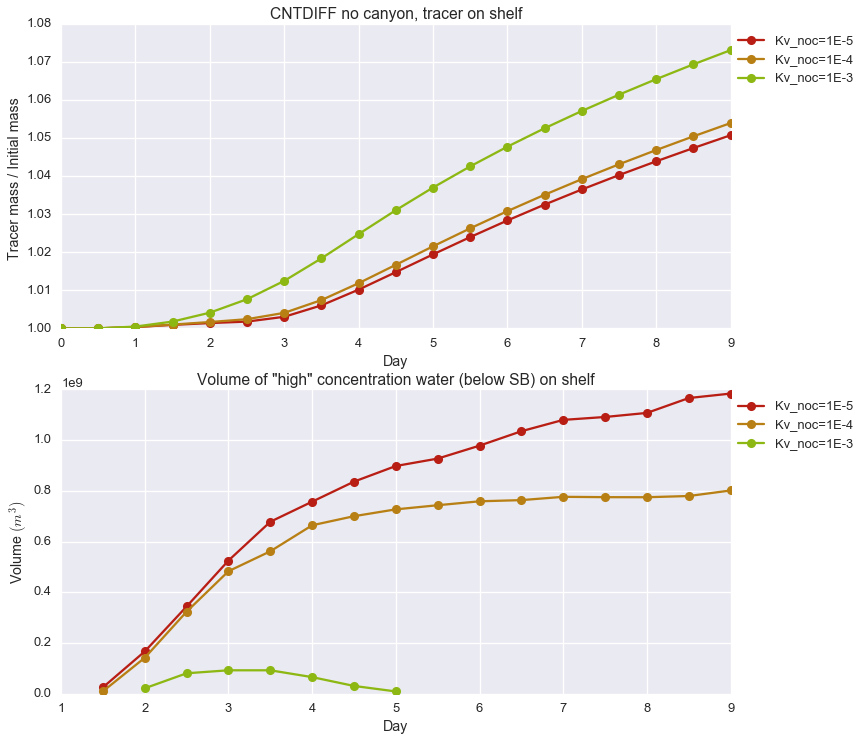

In [94]:
sns.set_palette( sns.hls_palette(10, l=.4, s=.8)) 

fig45=plt.figure(figsize=(12,12))

ax1 = plt.subplot(2,1,1)
ax1.plot(times/2.0, TrOnSh[:,10]/TrOnSh[0,10],'o-', label = labels[10])
ax1.plot(times/2.0, TrOnSh[:,11]/TrOnSh[0,11],'o-', label = labels[11])
ax1.plot(times/2.0, TrOnSh[:,12]/TrOnSh[0,12],'o-', label = labels[12])
plt.legend(loc="upper right", bbox_to_anchor=(1.2,1))
plt.ylabel('Tracer mass / Initial mass ')
plt.xlabel('Day')
plt.title('CNTDIFF no canyon, tracer on shelf')


ax1 = plt.subplot(2,1,2)
ax1.plot(times/2.0, HWC[:,10],'o-', label = labels[10])
ax1.plot(times/2.0, HWC[:,11],'o-', label = labels[11])
ax1.plot(times/2.0, HWC[:,12],'o-', label = labels[12])

plt.legend(loc="upper right", bbox_to_anchor=(1.2,1))
plt.ylabel('Volume $(m^3)$ ')
plt.xlabel('Day')
plt.title('Volume of "high" concentration water (below SB) on shelf')

#fig45.savefig('results/figures/CStransport/TronShCNTNoC_3Tr.eps', format='eps', dpi=1000, bbox_inches='tight')
print((TrOnSh[18,10]/TrOnSh[0,10])-(TrOnSh[18,12]/TrOnSh[0,12]))
print((TrOnSh[18,10]/TrOnSh[0,10]))
print((TrOnSh[18,12]/TrOnSh[0,12]))

### Relative magnitude of each transect's transport w.r.t. no canyon case Kv=$10^{-5}m^2s^{-1}$

/Users/Karina/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


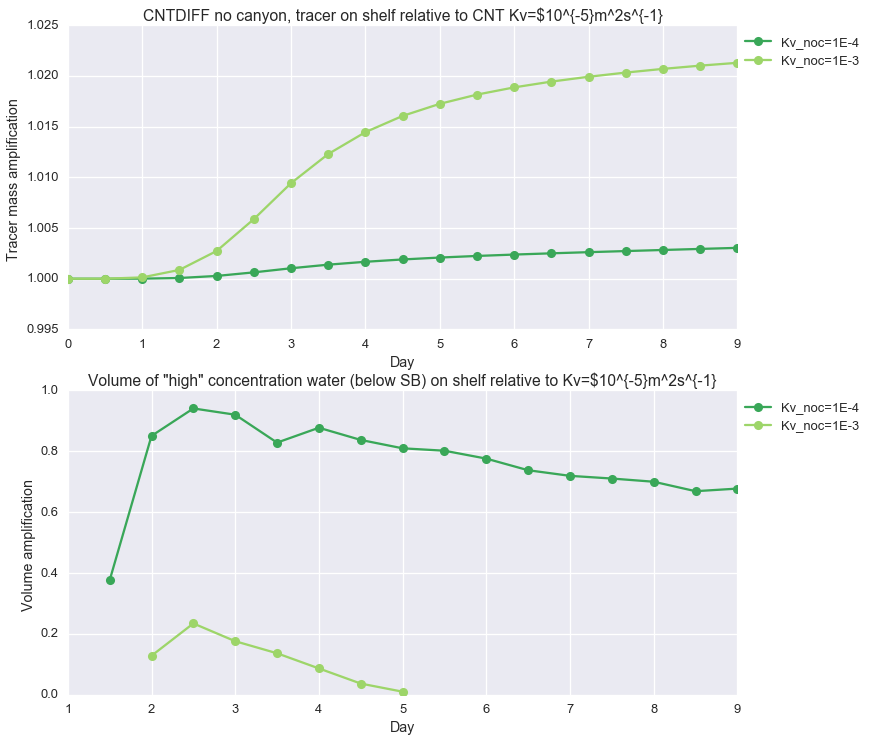

In [95]:
sns.set_palette('RdYlGn_r') 
means = np.zeros((2,4))
fig45=plt.figure(figsize=(12,12))

ax1 = plt.subplot(2,1,1)
ax1.plot(times/2.0, TrOnSh[:,11]/TrOnSh[:,10],'o-', label = labels[11])
ax1.plot(times/2.0, TrOnSh[:,12]/TrOnSh[:,10],'o-', label = labels[12])
plt.legend(loc="upper right", bbox_to_anchor=(1.2,1))
plt.ylabel('Tracer mass amplification ')
plt.xlabel('Day')
plt.title('CNTDIFF no canyon, tracer on shelf relative to CNT Kv=$10^{-5}m^2s^{-1}')


ax1 = plt.subplot(2,1,2)
ax1.plot(times/2.0, HWC[:,11]/HWC[:,10],'o-', label = labels[11])
ax1.plot(times/2.0, HWC[:,12]/HWC[:,10],'o-', label = labels[12])

plt.legend(loc="upper right", bbox_to_anchor=(1.2,1))
plt.ylabel('Volume amplification ')
plt.xlabel('Day')
plt.title('Volume of "high" concentration water (below SB) on shelf relative to Kv=$10^{-5}m^2s^{-1}')

means[0,0] = np.mean(TrOnSh[:,11]/TrOnSh[:,10])
means[0,1] = np.mean(TrOnSh[:,11]/TrOnSh[:,10])
means[1,0] = np.std(TrOnSh[:,12]/TrOnSh[:,10])
means[1,1] = np.std(TrOnSh[:,12]/TrOnSh[:,10])

means[0,2] = np.mean(HWC[:,11]/HWC[:,10])
means[0,3] = np.mean(HWC[:,11]/HWC[:,10])
means[1,2] = np.std(HWC[:,12]/HWC[:,10])
means[1,3] = np.std(HWC[:,12]/HWC[:,10])


#fig45.savefig('results/figures/CStransport/TronShCNTNoC_3Tr_Amplification.eps', format='eps', dpi=1000, bbox_inches='tight')


In [96]:
print(means[0,:])
print(means[1,:])

[ 1.00159763  1.00159763         nan         nan]
[ 0.00808261  0.00808261         nan         nan]


### Canyon case - changing vertical diffusivity

0.00103968169528
0.0107401386463
1.08948685804
1.07874671939


/Users/Karina/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


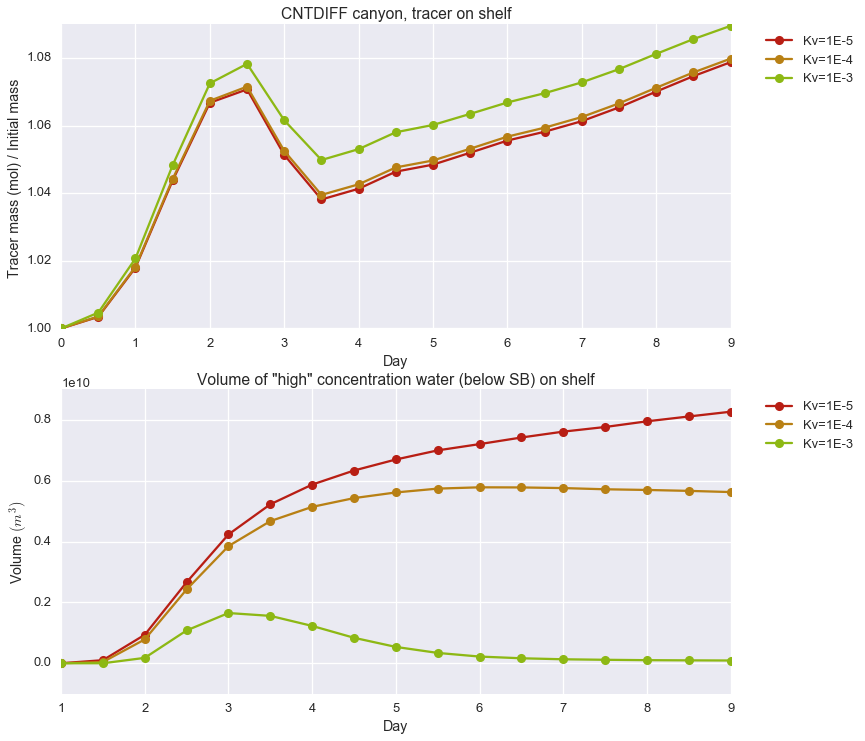

In [116]:
sns.set_palette( sns.hls_palette(10, l=.4, s=.8)) 

fig45=plt.figure(figsize=(12,12))

ax1 = plt.subplot(2,1,1)
ax1.plot(times/2.0, TrOnSh[:,4]/TrOnSh[0,4],'o-', label = labels[4])
ax1.plot(times/2.0, TrOnSh[:,5]/TrOnSh[0,5],'o-', label = labels[5])
ax1.plot(times/2.0, TrOnSh[:,6]/TrOnSh[0,6],'o-', label = labels[6])
plt.legend(loc="upper right", bbox_to_anchor=(1.2,1))
plt.ylabel('Tracer mass (mol) / Initial mass ')
plt.xlabel('Day')
plt.title('CNTDIFF canyon, tracer on shelf')


ax1 = plt.subplot(2,1,2)
ax1.plot(times/2.0, HWC[:,4],'o-', label = labels[4])
ax1.plot(times/2.0, HWC[:,5],'o-', label = labels[5])
ax1.plot(times/2.0, HWC[:,6],'o-', label = labels[6])

plt.legend(loc="upper right", bbox_to_anchor=(1.2,1))
plt.ylabel('Volume $(m^3)$ ')
plt.xlabel('Day')
plt.title('Volume of "high" concentration water (below SB) on shelf')

print((TrOnSh[18,5]/TrOnSh[0,5])-(TrOnSh[18,4]/TrOnSh[0,4]))
print((TrOnSh[18,6]/TrOnSh[0,6])-(TrOnSh[18,4]/TrOnSh[0,4]))
print((TrOnSh[18,6]/TrOnSh[0,6]))
print((TrOnSh[18,4]/TrOnSh[0,4]))
#fig45.savefig('results/figures/CStransport/TronShCNT_3Tr.eps', format='eps', dpi=1000, bbox_inches='tight')


/Users/Karina/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


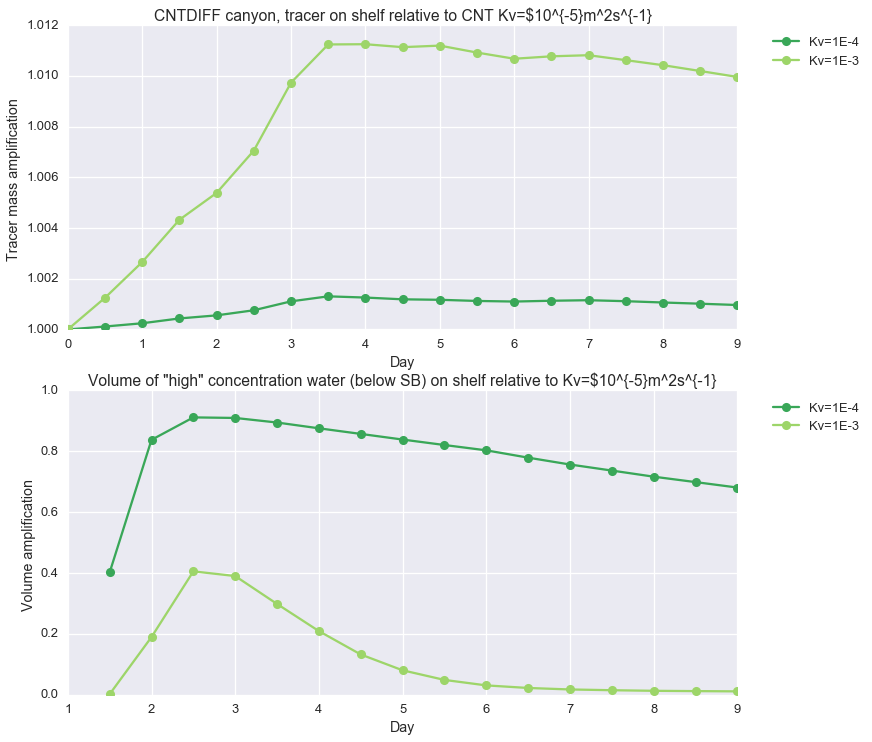

In [117]:
sns.set_palette('RdYlGn_r') 
means = np.zeros((2,4))
fig45=plt.figure(figsize=(12,12))

ax1 = plt.subplot(2,1,1)
ax1.plot(times/2.0, TrOnSh[:,5]/TrOnSh[:,4],'o-', label = labels[5])
ax1.plot(times/2.0, TrOnSh[:,6]/TrOnSh[:,4],'o-', label = labels[6])
plt.legend(loc="upper right", bbox_to_anchor=(1.2,1))
plt.ylabel('Tracer mass amplification ')
plt.xlabel('Day')
plt.title('CNTDIFF canyon, tracer on shelf relative to CNT Kv=$10^{-5}m^2s^{-1}')


ax1 = plt.subplot(2,1,2)
ax1.plot(times/2.0, HWC[:,5]/HWC[:,4],'o-', label = labels[5])
ax1.plot(times/2.0, HWC[:,6]/HWC[:,4],'o-', label = labels[6])

plt.legend(loc="upper right", bbox_to_anchor=(1.2,1))
plt.ylabel('Volume amplification ')
plt.xlabel('Day')
plt.title('Volume of "high" concentration water (below SB) on shelf relative to Kv=$10^{-5}m^2s^{-1}')

means[0,0] = np.mean(TrOnSh[:,5]/TrOnSh[:,4])
means[0,1] = np.mean(TrOnSh[:,5]/TrOnSh[:,4])
means[1,0] = np.std(TrOnSh[:,6]/TrOnSh[:,4])
means[1,1] = np.std(TrOnSh[:,6]/TrOnSh[:,4])

means[0,2] = np.mean(HWC[:,5]/HWC[:,4])
means[0,3] = np.mean(HWC[:,5]/HWC[:,4])
means[1,2] = np.std(HWC[:,6]/HWC[:,4])
means[1,3] = np.std(HWC[:,6]/HWC[:,4])



#fig45.savefig('results/figures/CStransport/TronShCNT_3Tr_Amplification.eps', format='eps', dpi=1000, bbox_inches='tight')


In [99]:
means

array([[ 1.00088445,  1.00088445,         nan,         nan],
       [ 0.00364859,  0.00364859,         nan,         nan]])

### Canyon - no canyon for different diffusivities

1.07874671939
1.05079526318


/Users/Karina/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


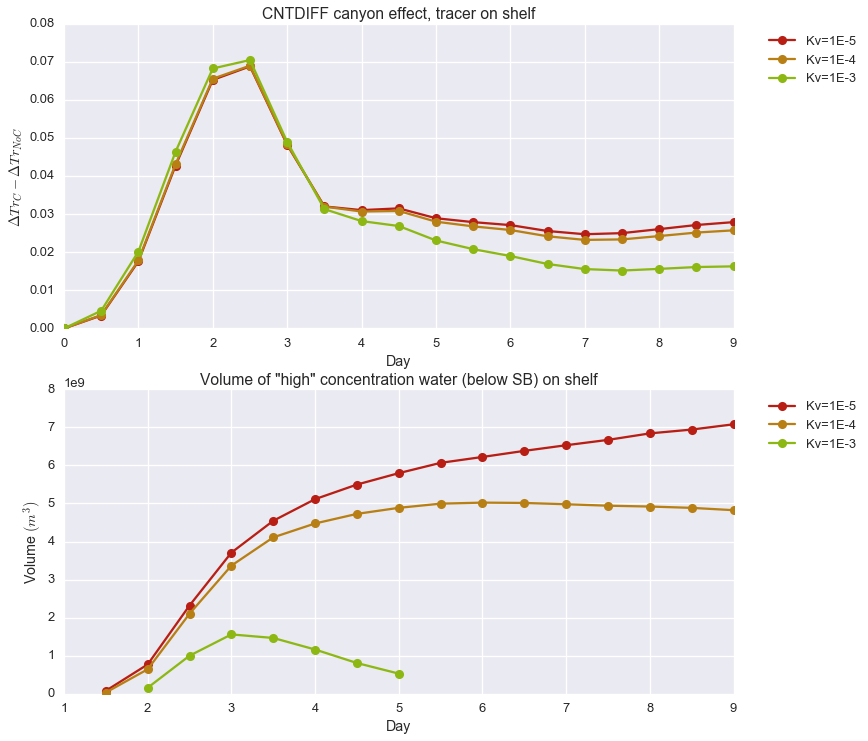

In [100]:
sns.set_palette( sns.hls_palette(10, l=.4, s=.8)) 
sns.set_palette( sns.hls_palette(10, l=.4, s=.8)) 

fig45=plt.figure(figsize=(12,12))

ax1 = plt.subplot(2,1,1)
ax1.plot(times/2.0, (TrOnSh[:,4]/TrOnSh[0,4])-(TrOnSh[:,10]/TrOnSh[0,10]),'o-', label = labels[4])
ax1.plot(times/2.0, (TrOnSh[:,5]/TrOnSh[0,5])-(TrOnSh[:,11]/TrOnSh[0,11]),'o-', label = labels[5])
ax1.plot(times/2.0, (TrOnSh[:,6]/TrOnSh[0,6])-(TrOnSh[:,12]/TrOnSh[0,12]),'o-', label = labels[6])
plt.legend(loc="upper right", bbox_to_anchor=(1.2,1))
plt.ylabel('$\Delta Tr_C-\Delta Tr_{NoC}$ ')
plt.xlabel('Day')
plt.title('CNTDIFF canyon effect, tracer on shelf')


ax1 = plt.subplot(2,1,2)
ax1.plot(times/2.0, HWC[:,4]-HWC[:,10],'o-', label = labels[4])
ax1.plot(times/2.0, HWC[:,5]-HWC[:,11],'o-', label = labels[5])
ax1.plot(times/2.0, HWC[:,6]-HWC[:,12],'o-', label = labels[6])

plt.legend(loc="upper right", bbox_to_anchor=(1.2,1))
plt.ylabel('Volume $(m^3)$ ')
plt.xlabel('Day')
plt.title('Volume of "high" concentration water (below SB) on shelf')



#fig45.savefig('results/figures/CStransport/TronShCNT_3Tr_DifferenceNoC.eps', format='eps', dpi=1000, bbox_inches='tight')
print(TrOnSh[18,4]/TrOnSh[0,4])
print(TrOnSh[18,10]/TrOnSh[0,10])

### Changing geography of mixing

/Users/Karina/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


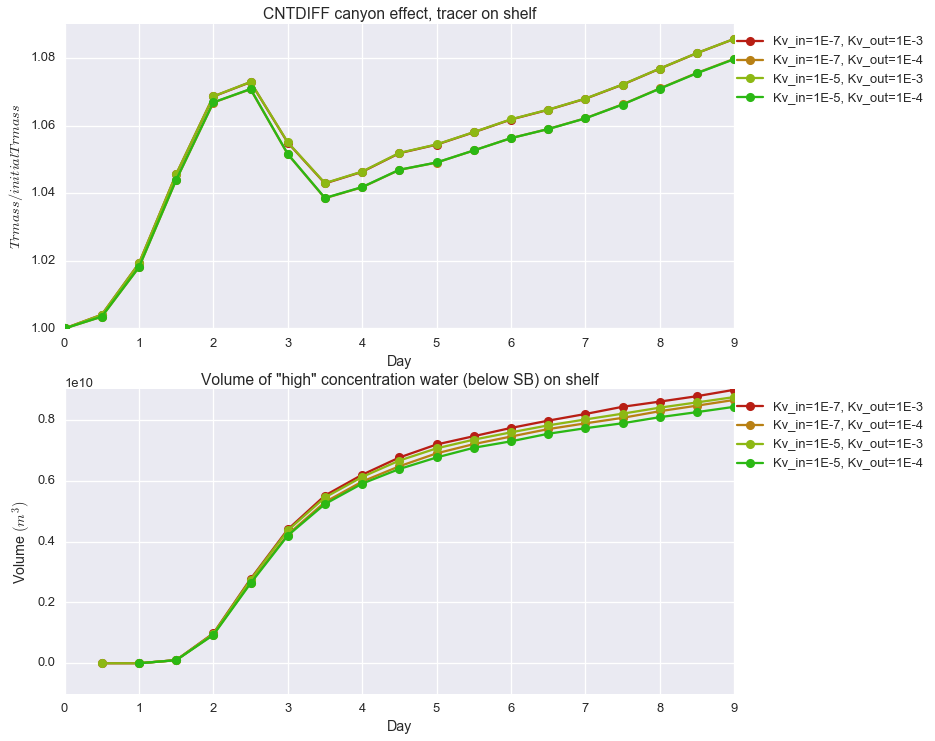

In [120]:
sns.set_palette( sns.hls_palette(10, l=.4, s=.8)) 
sns.set_palette( sns.hls_palette(10, l=.4, s=.8)) 

fig45=plt.figure(figsize=(12,12))

ax1 = plt.subplot(2,1,1)
ax1.plot(times/2.0, (TrOnSh[:,0]/TrOnSh[0,0]),'o-', label = labels[0])
ax1.plot(times/2.0, (TrOnSh[:,1]/TrOnSh[0,1]),'o-', label = labels[1])
ax1.plot(times/2.0, (TrOnSh[:,2]/TrOnSh[0,2]),'o-', label = labels[2])
ax1.plot(times/2.0, (TrOnSh[:,3]/TrOnSh[0,3]),'o-', label = labels[3])

plt.legend(loc="upper right", bbox_to_anchor=(1.3,1))
plt.ylabel('$Tr mass/ initial Tr mass$ ')
plt.xlabel('Day')
plt.title('CNTDIFF canyon effect, tracer on shelf')


ax2 = plt.subplot(2,1,2)
ax2.plot(times/2.0, HWC[:,0],'o-', label = labels[0])
ax2.plot(times/2.0, HWC[:,1],'o-', label = labels[1])
ax2.plot(times/2.0, HWC[:,2],'o-', label = labels[2])
ax2.plot(times/2.0, HWC[:,3],'o-', label = labels[3])

plt.legend(loc="upper right", bbox_to_anchor=(1.3,1))
plt.ylabel('Volume $(m^3)$ ')
plt.xlabel('Day')
plt.title('Volume of "high" concentration water (below SB) on shelf')



#fig45.savefig('results/figures/CStransport/TronShCNT_3Tr_DifferenceNoC.eps', format='eps', dpi=1000, bbox_inches='tight')


### Checking if it's the geography of mixing or the average diffusivity of that case

/Users/Karina/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


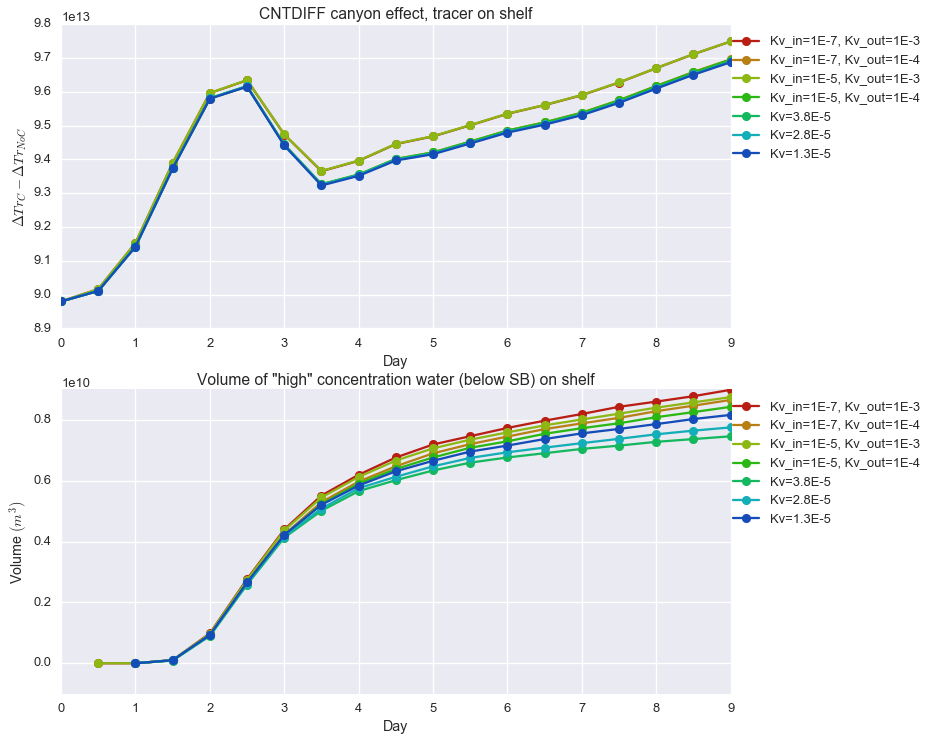

In [121]:
sns.set_palette( sns.hls_palette(10, l=.4, s=.8)) 
sns.set_palette( sns.hls_palette(10, l=.4, s=.8)) 

fig45=plt.figure(figsize=(12,12))

ax1 = plt.subplot(2,1,1)

ax1.plot(times/2.0, (TrOnSh[:,0]),'o-', label = labels[0])
ax1.plot(times/2.0, (TrOnSh[:,1]),'o-', label = labels[1])
ax1.plot(times/2.0, (TrOnSh[:,2]),'o-', label = labels[2])
ax1.plot(times/2.0, (TrOnSh[:,3]),'o-', label = labels[3])

ax1.plot(times/2.0, (TrOnSh[:,19]),'o-', label = labels[19])
ax1.plot(times/2.0, (TrOnSh[:,20]),'o-', label = labels[20])
ax1.plot(times/2.0, (TrOnSh[:,21]),'o-', label = labels[21])

plt.legend(loc="upper right", bbox_to_anchor=(1.3,1))
plt.ylabel('$\Delta Tr_C-\Delta Tr_{NoC}$ ')
plt.xlabel('Day')
plt.title('CNTDIFF canyon effect, tracer on shelf')


ax1 = plt.subplot(2,1,2)
ax1.plot(times/2.0, HWC[:,0],'o-', label = labels[0])
ax1.plot(times/2.0, HWC[:,1],'o-', label = labels[1])
ax1.plot(times/2.0, HWC[:,2],'o-', label = labels[2])
ax1.plot(times/2.0, HWC[:,3],'o-', label = labels[3])

ax1.plot(times/2.0, HWC[:,19],'o-', label = labels[19])
ax1.plot(times/2.0, HWC[:,20],'o-', label = labels[20])
ax1.plot(times/2.0, HWC[:,21],'o-', label = labels[21])


plt.legend(loc="upper right", bbox_to_anchor=(1.3,1))
plt.ylabel('Volume $(m^3)$ ')
plt.xlabel('Day')
plt.title('Volume of "high" concentration water (below SB) on shelf')



#fig45.savefig('results/figures/CStransport/TronShCNT_3Tr_DifferenceNoC.eps', format='eps', dpi=1000, bbox_inches='tight')


/Users/Karina/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


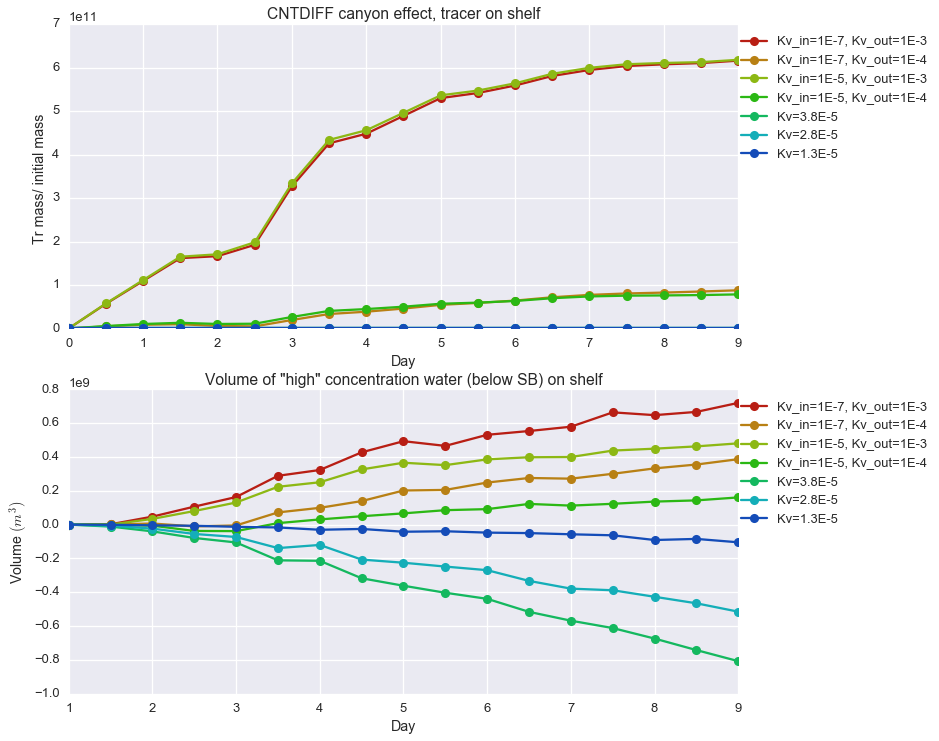

In [102]:
sns.set_palette( sns.hls_palette(10, l=.4, s=.8)) 
sns.set_palette( sns.hls_palette(10, l=.4, s=.8)) 

fig45=plt.figure(figsize=(12,12))

ax1 = plt.subplot(2,1,1)

ax1.plot(times/2.0, (TrOnSh[:,0]-TrOnSh[:,4]),'o-', label = labels[0])
ax1.plot(times/2.0, (TrOnSh[:,1]-TrOnSh[:,4]),'o-', label = labels[1])
ax1.plot(times/2.0, (TrOnSh[:,2]-TrOnSh[:,4]),'o-', label = labels[2])
ax1.plot(times/2.0, (TrOnSh[:,3]-TrOnSh[:,4]),'o-', label = labels[3])

ax1.plot(times/2.0, (TrOnSh[:,19]/TrOnSh[0,19]),'o-', label = labels[19])
ax1.plot(times/2.0, (TrOnSh[:,20]/TrOnSh[0,20]),'o-', label = labels[20])
ax1.plot(times/2.0, (TrOnSh[:,21]/TrOnSh[0,21]),'o-', label = labels[21])

plt.legend(loc="upper right", bbox_to_anchor=(1.3,1))
plt.ylabel('Tr mass/ initial mass ')
plt.xlabel('Day')
plt.title('CNTDIFF canyon effect, tracer on shelf')


ax1 = plt.subplot(2,1,2)
ax1.plot(times/2.0, HWC[:,0]-HWC[:,4],'o-', label = labels[0])
ax1.plot(times/2.0, HWC[:,1]-HWC[:,4],'o-', label = labels[1])
ax1.plot(times/2.0, HWC[:,2]-HWC[:,4],'o-', label = labels[2])
ax1.plot(times/2.0, HWC[:,3]-HWC[:,4],'o-', label = labels[3])

ax1.plot(times/2.0, HWC[:,19]-HWC[:,4],'o-', label = labels[19])
ax1.plot(times/2.0, HWC[:,20]-HWC[:,4],'o-', label = labels[20])
ax1.plot(times/2.0, HWC[:,21]-HWC[:,4],'o-', label = labels[21])


plt.legend(loc="upper right", bbox_to_anchor=(1.3,1))
plt.ylabel('Volume $(m^3)$ ')
plt.xlabel('Day')
plt.title('Volume of "high" concentration water (below SB) on shelf')



#fig45.savefig('results/figures/CStransport/TronShCNT_3Tr_DifferenceNoC.eps', format='eps', dpi=1000, bbox_inches='tight')


## Non-dimensional numbers

In [103]:
Peh = np.zeros(19) # 13 tracers
Pev = np.zeros(19) # 13 tracers
K = np.zeros(19)

kd = np.array([np.mean([1.E-7,1.E-3]),np.mean([1.E-7,1.E-4]),np.mean([1.E-5,1.E-3]),np.mean([1.E-5,1.E-4]),
               1.E-5,1.E-4,1.E-3,(3.81)*1.E-5,(2.8)*1.E-5,(1.3)*1.E-5,1.E-5,1.E-4,1.E-3,1.E-5,1.E-4,1.E-3,
               1.E-5,1.E-4,1.E-3,(3.81)*1.E-5,(2.8)*1.E-5,(1.3)*1.E-5])

ki = np.array([1.0,1.0,1.0,1.0,1.0,1.0,1.0,10.0,10.0,10.0,1.0,1.0,1.0,10.0,10.0,10.0,0.1,0.1,0.1,1.0,1.0,1.0])

L = 6400.0 # meters
U = 6.60E-2 # ms−1 Barkley - change for mine
Z =21.7 # m Barkley - change for mine
Om = 2.23E-4 # Barkley - change for mine


Peh = (L*U)/ki
Pev = (Z*Om)/kd
K = (Z*Z*ki)/(L*L*kd)

print(Peh)
print(Pev)
print(K)

[  422.4    422.4    422.4    422.4    422.4    422.4    422.4     42.24
    42.24    42.24   422.4    422.4    422.4     42.24    42.24    42.24
  4224.    4224.    4224.     422.4    422.4    422.4 ]
[   9.67723228   96.68531469    9.58237624   87.98363636  483.91         48.391
    4.8391      127.01049869  172.825       372.23846154  483.91         48.391
    4.8391      483.91         48.391         4.8391      483.91         48.391
    4.8391      127.01049869  172.825       372.23846154]
[  2.29903767e-02   2.29697061e-01   2.27650255e-02   2.09024325e-01
   1.14963379e+00   1.14963379e-01   1.14963379e-02   3.01741152e+00
   4.10583496e+00   8.84333684e+00   1.14963379e+00   1.14963379e-01
   1.14963379e-02   1.14963379e+01   1.14963379e+00   1.14963379e-01
   1.14963379e-01   1.14963379e-02   1.14963379e-03   3.01741152e-01
   4.10583496e-01   8.84333684e-01]


In [21]:
TrOnShList = [TrOnSh[:,0], TrOnSh[:,1],TrOnSh[:,2],TrOnSh[:,3], TrOnSh[:,4],TrOnSh[:,5], TrOnSh[:,6]
              ,TrOnSh[:,7],TrOnSh[:,8], TrOnSh[:,9],TrOnSh[:,13], TrOnSh[:,14], TrOnSh[:,15],TrOnSh[:,16],
              TrOnSh[:,17], TrOnSh[:,18],TrOnSh[:,19],TrOnSh[:,20], TrOnSh[:,21]]
HWCList = [HWC[:,0], HWC[:,1],HWC[:,2],HWC[:,3], HWC[:,4],HWC[:,5], HWC[:,6],HWC[:,7],HWC[:,8], HWC[:,9],
           HWC[:,13],HWC[:,14], HWC[:,15],HWC[:,16],HWC[:,17], HWC[:,18],HWC[:,19],HWC[:,20], HWC[:,21]]

sns.set_palette( 'Set1',9)
fig42=plt.figure(figsize=(12,6))

marker = ['s','s','s','s','o','o','o','*','*','*','d','d','d','^','^','^','>','>','>']
jj=0

indexList = [0,1,2,3,4,5,6,7,8,9,13,14,15,16,17,18,19,20,21]

    
# ADVECTIVE PHASE ONLY - TIME INTEGRATED CROSS-SHELF TRANSPORT
for ii,tot,vert in zip(indexList, TrOnShList,HWCList):
    ax1 = plt.subplot(1,2,1)
    plt.plot( K[ii] ,np.mean(tot[10:]),marker[jj], markersize = 13,alpha = 0.8,label = labels[ii])
    plt.ylabel('Mean tr mass (mol/l)')
    plt.xlabel('K')
    plt.title(' Tracer on canyon box - Advective phase ')
    ax1.set_xscale("log", nonposy='clip')
    
    ax2 = plt.subplot(1,2,2)
    plt.plot(K[ii] , np.nanmean(vert[10:]),marker[jj], markersize = 13,alpha = 0.8,label = labels[ii])
    plt.ylabel('Mean volume HCW ($m^3$)')
    plt.xlabel('K')
    plt.title('HCW on canyon box - Advective phase ')
    #ax2.set_xscale("log", nonposy='clip')
    jj = jj+1

ax2.legend(loc ='upper right', bbox_to_anchor=(1.7,1))
#ax2.legend(loc =0)

NameError: name 'TrOnSh' is not defined

/Users/Karina/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


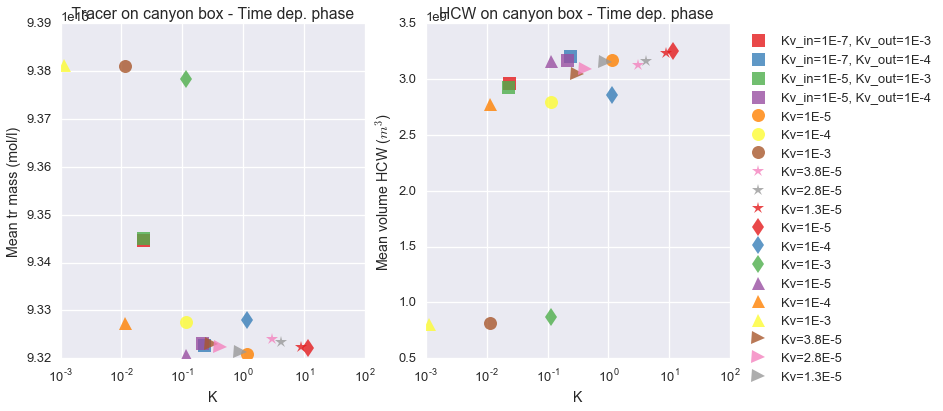

In [105]:
TrOnShList = [TrOnSh[:,0], TrOnSh[:,1],TrOnSh[:,2],TrOnSh[:,3], TrOnSh[:,4],TrOnSh[:,5], TrOnSh[:,6]
              ,TrOnSh[:,7],TrOnSh[:,8], TrOnSh[:,9],TrOnSh[:,13], TrOnSh[:,14], TrOnSh[:,15],TrOnSh[:,16],
              TrOnSh[:,17], TrOnSh[:,18],TrOnSh[:,19],TrOnSh[:,20], TrOnSh[:,21]]
HWCList = [HWC[:,0], HWC[:,1],HWC[:,2],HWC[:,3], HWC[:,4],HWC[:,5], HWC[:,6],HWC[:,7],HWC[:,8], HWC[:,9],
           HWC[:,13],HWC[:,14], HWC[:,15],HWC[:,16],HWC[:,17], HWC[:,18],HWC[:,19],HWC[:,20], HWC[:,21]]

sns.set_palette( 'Set1',10)
fig42=plt.figure(figsize=(12,6))

marker = ['s','s','s','s','o','o','o','*','*','*','d','d','d','^','^','^','>','>','>']
jj=0

indexList = [0,1,2,3,4,5,6,7,8,9,13,14,15,16,17,18,19,20,21]

    
# ADVECTIVE PHASE ONLY - TIME INTEGRATED CROSS-SHELF TRANSPORT
for ii,tot,vert in zip(indexList, TrOnShList,HWCList):
    ax1 = plt.subplot(1,2,1)
    plt.plot( K[ii] ,np.mean(tot[:10]),marker[jj], markersize = 13,alpha = 0.8,label = labels[ii])
    plt.ylabel('Mean tr mass (mol/l)')
    plt.xlabel('K')
    plt.title(' Tracer on canyon box - Time dep. phase ')
    ax1.set_xscale("log", nonposy='clip')
    
    ax2 = plt.subplot(1,2,2)
    plt.plot(K[ii] , np.nanmean(vert[:10]),marker[jj], markersize = 13,alpha = 0.8,label = labels[ii])
    plt.ylabel('Mean volume HCW ($m^3$)')
    plt.xlabel('K')
    plt.title('HCW on canyon box - Time dep. phase ')
    ax2.set_xscale("log", nonposy='clip')
    jj = jj+1

ax2.legend(loc ='upper right', bbox_to_anchor=(1.7,1))
#ax2.legend(loc =0)

/Users/Karina/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


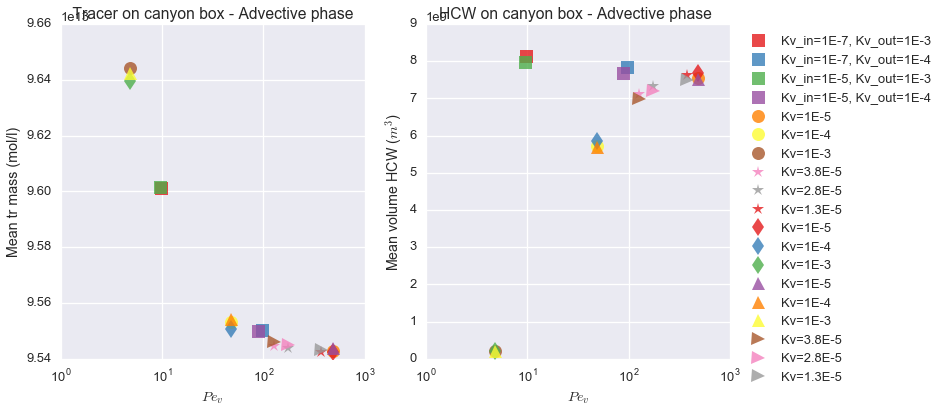

In [106]:
TrOnShList = [TrOnSh[:,0], TrOnSh[:,1],TrOnSh[:,2],TrOnSh[:,3], TrOnSh[:,4],TrOnSh[:,5], TrOnSh[:,6]
              ,TrOnSh[:,7],TrOnSh[:,8], TrOnSh[:,9],TrOnSh[:,13], TrOnSh[:,14], TrOnSh[:,15],TrOnSh[:,16],
              TrOnSh[:,17], TrOnSh[:,18],TrOnSh[:,19],TrOnSh[:,20], TrOnSh[:,21]]
HWCList = [HWC[:,0], HWC[:,1],HWC[:,2],HWC[:,3], HWC[:,4],HWC[:,5], HWC[:,6],HWC[:,7],HWC[:,8], HWC[:,9],
           HWC[:,13],HWC[:,14], HWC[:,15],HWC[:,16],HWC[:,17], HWC[:,18],HWC[:,19],HWC[:,20], HWC[:,21]]

sns.set_palette( 'Set1',10)
fig42=plt.figure(figsize=(12,6))

marker = ['s','s','s','s','o','o','o','*','*','*','d','d','d','^','^','^','>','>','>']
jj=0

indexList = [0,1,2,3,4,5,6,7,8,9,13,14,15,16,17,18,19,20,21]

    
# ADVECTIVE PHASE ONLY - TIME INTEGRATED CROSS-SHELF TRANSPORT
for ii,tot,vert in zip(indexList, TrOnShList,HWCList):
    ax1 = plt.subplot(1,2,1)
    plt.plot( Pev[ii] ,np.mean(tot[10:]),marker[jj], markersize = 13,alpha = 0.8,label = labels[ii])
    plt.ylabel('Mean tr mass (mol/l)')
    plt.xlabel('$Pe_v$')
    plt.title(' Tracer on canyon box - Advective phase ')
    ax1.set_xscale("log", nonposy='clip')
    
    ax2 = plt.subplot(1,2,2)
    plt.plot(Pev[ii] , np.nanmean(vert[10:]),marker[jj], markersize = 13,alpha = 0.8,label = labels[ii])
    plt.ylabel('Mean volume HCW ($m^3$)')
    plt.xlabel('$Pe_v$')
    plt.title('HCW on canyon box - Advective phase ')
    ax2.set_xscale("log", nonposy='clip')
    jj = jj+1

ax2.legend(loc ='upper right', bbox_to_anchor=(1.7,1))
#ax2.legend(l

/Users/Karina/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


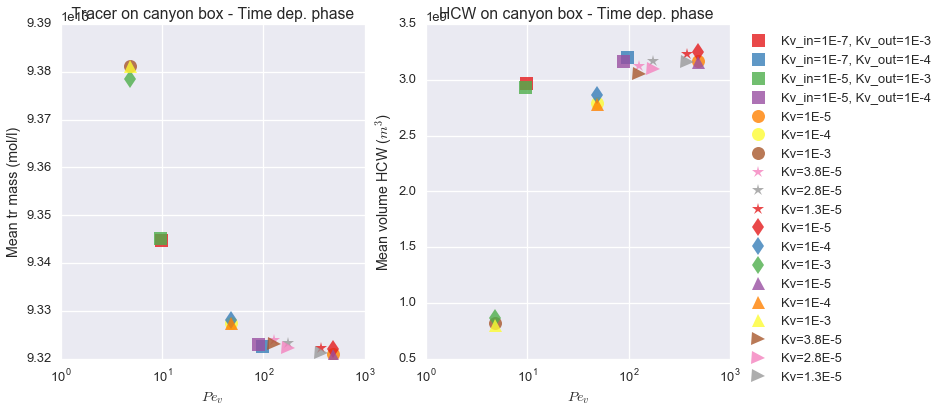

In [107]:
TrOnShList = [TrOnSh[:,0], TrOnSh[:,1],TrOnSh[:,2],TrOnSh[:,3], TrOnSh[:,4],TrOnSh[:,5], TrOnSh[:,6]
              ,TrOnSh[:,7],TrOnSh[:,8], TrOnSh[:,9],TrOnSh[:,13], TrOnSh[:,14], TrOnSh[:,15],TrOnSh[:,16],
              TrOnSh[:,17], TrOnSh[:,18],TrOnSh[:,19],TrOnSh[:,20], TrOnSh[:,21]]
HWCList = [HWC[:,0], HWC[:,1],HWC[:,2],HWC[:,3], HWC[:,4],HWC[:,5], HWC[:,6],HWC[:,7],HWC[:,8], HWC[:,9],
           HWC[:,13],HWC[:,14], HWC[:,15],HWC[:,16],HWC[:,17], HWC[:,18],HWC[:,19],HWC[:,20], HWC[:,21]]

sns.set_palette( 'Set1',10)
fig42=plt.figure(figsize=(12,6))

marker = ['s','s','s','s','o','o','o','*','*','*','d','d','d','^','^','^','>','>','>']
jj=0

indexList = [0,1,2,3,4,5,6,7,8,9,13,14,15,16,17,18,19,20,21]

    
# ADVECTIVE PHASE ONLY - TIME INTEGRATED CROSS-SHELF TRANSPORT
for ii,tot,vert in zip(indexList, TrOnShList,HWCList):
    ax1 = plt.subplot(1,2,1)
    plt.plot( Pev[ii] ,np.mean(tot[:10]),marker[jj], markersize = 13,alpha = 0.8,label = labels[ii])
    plt.ylabel('Mean tr mass (mol/l)')
    plt.xlabel('$Pe_v$')
    plt.title(' Tracer on canyon box - Time dep. phase ')
    ax1.set_xscale("log", nonposy='clip')
    
    ax2 = plt.subplot(1,2,2)
    plt.plot(Pev[ii] , np.nanmean(vert[:10]),marker[jj], markersize = 13,alpha = 0.8,label = labels[ii])
    plt.ylabel('Mean volume HCW ($m^3$)')
    plt.xlabel('$Pe_v$')
    plt.title('HCW on canyon box - Time dep. phase ')
    ax2.set_xscale("log", nonposy='clip')
    jj = jj+1

ax2.legend(loc ='upper right', bbox_to_anchor=(1.7,1))
#ax2.legend(l

/Users/Karina/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


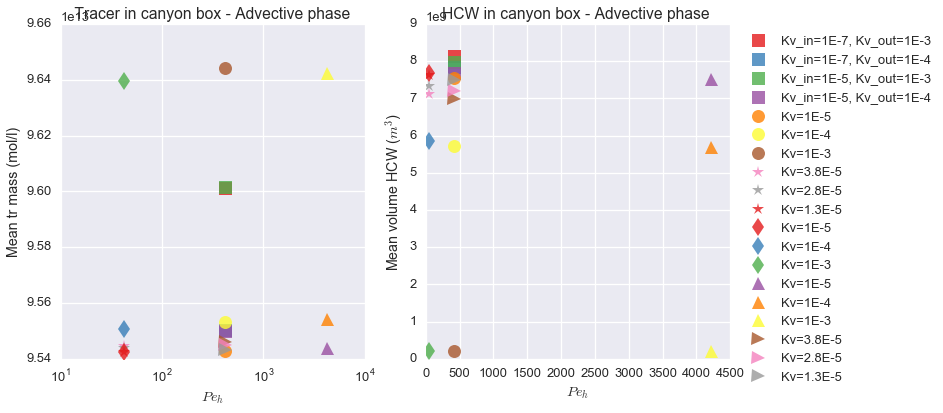

In [108]:
TrOnShList = [TrOnSh[:,0], TrOnSh[:,1],TrOnSh[:,2],TrOnSh[:,3], TrOnSh[:,4],TrOnSh[:,5], TrOnSh[:,6]
              ,TrOnSh[:,7],TrOnSh[:,8], TrOnSh[:,9],TrOnSh[:,13], TrOnSh[:,14], TrOnSh[:,15],TrOnSh[:,16],
              TrOnSh[:,17], TrOnSh[:,18],TrOnSh[:,19],TrOnSh[:,20], TrOnSh[:,21]]
HWCList = [HWC[:,0], HWC[:,1],HWC[:,2],HWC[:,3], HWC[:,4],HWC[:,5], HWC[:,6],HWC[:,7],HWC[:,8], HWC[:,9],
           HWC[:,13],HWC[:,14], HWC[:,15],HWC[:,16],HWC[:,17], HWC[:,18],HWC[:,19],HWC[:,20], HWC[:,21]]

sns.set_palette( 'Set1',10)
fig42=plt.figure(figsize=(12,6))

marker = ['s','s','s','s','o','o','o','*','*','*','d','d','d','^','^','^','>','>','>']
jj=0

indexList = [0,1,2,3,4,5,6,7,8,9,13,14,15,16,17,18,19,20,21]

    
# ADVECTIVE PHASE ONLY - TIME INTEGRATED CROSS-SHELF TRANSPORT
for ii,tot,vert in zip(indexList, TrOnShList,HWCList):
    ax1 = plt.subplot(1,2,1)
    plt.plot( Peh[ii] ,np.mean(tot[10:]),marker[jj], markersize = 13,alpha = 0.8,label = labels[ii])
    plt.ylabel('Mean tr mass (mol/l)')
    plt.xlabel('$Pe_h$')
    plt.title(' Tracer in canyon box - Advective phase ')
    ax1.set_xscale("log", nonposy='clip')
    
    ax2 = plt.subplot(1,2,2)
    plt.plot(Peh[ii] , np.nanmean(vert[10:]),marker[jj], markersize = 13,alpha = 0.8,label = labels[ii])
    plt.ylabel('Mean volume HCW ($m^3$)')
    plt.xlabel('$Pe_h$')
    plt.title('HCW in canyon box - Advective phase ')
    #ax2.set_xscale("log", nonposy='clip')
    jj = jj+1

ax2.legend(loc ='upper right', bbox_to_anchor=(1.7,1))
#ax2.legend(l

/Users/Karina/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


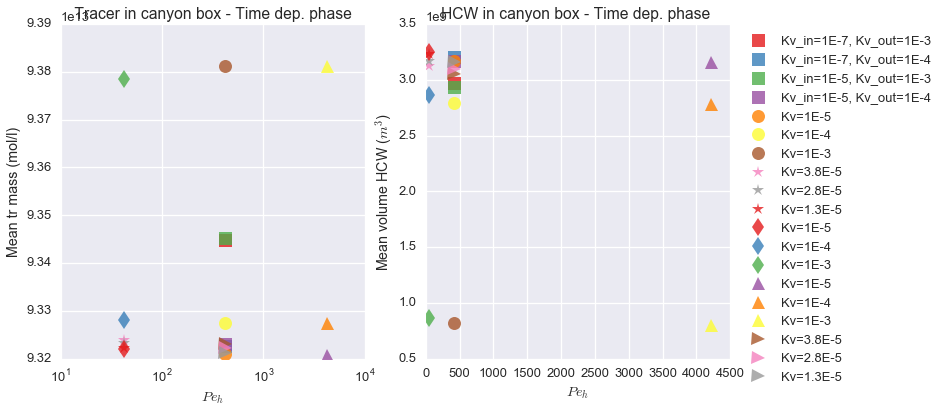

In [109]:
TrOnShList = [TrOnSh[:,0], TrOnSh[:,1],TrOnSh[:,2],TrOnSh[:,3], TrOnSh[:,4],TrOnSh[:,5], TrOnSh[:,6]
              ,TrOnSh[:,7],TrOnSh[:,8], TrOnSh[:,9],TrOnSh[:,13], TrOnSh[:,14], TrOnSh[:,15],TrOnSh[:,16],
              TrOnSh[:,17], TrOnSh[:,18],TrOnSh[:,19],TrOnSh[:,20], TrOnSh[:,21]]
HWCList = [HWC[:,0], HWC[:,1],HWC[:,2],HWC[:,3], HWC[:,4],HWC[:,5], HWC[:,6],HWC[:,7],HWC[:,8], HWC[:,9],
           HWC[:,13],HWC[:,14], HWC[:,15],HWC[:,16],HWC[:,17], HWC[:,18],HWC[:,19],HWC[:,20], HWC[:,21]]

sns.set_palette( 'Set1',10)
fig42=plt.figure(figsize=(12,6))

marker = ['s','s','s','s','o','o','o','*','*','*','d','d','d','^','^','^','>','>','>']
jj=0

indexList = [0,1,2,3,4,5,6,7,8,9,13,14,15,16,17,18,19,20,21]

    
# ADVECTIVE PHASE ONLY - TIME INTEGRATED CROSS-SHELF TRANSPORT
for ii,tot,vert in zip(indexList, TrOnShList,HWCList):
    ax1 = plt.subplot(1,2,1)
    plt.plot( Peh[ii] ,np.mean(tot[:10]),marker[jj], markersize = 13,alpha = 0.8,label = labels[ii])
    plt.ylabel('Mean tr mass (mol/l)')
    plt.xlabel('$Pe_h$')
    plt.title(' Tracer in canyon box - Time dep. phase ')
    ax1.set_xscale("log", nonposy='clip')
    
    ax2 = plt.subplot(1,2,2)
    plt.plot(Peh[ii] , np.nanmean(vert[:10]),marker[jj], markersize = 13,alpha = 0.8,label = labels[ii])
    plt.ylabel('Mean volume HCW ($m^3$)')
    plt.xlabel('$Pe_h$')
    plt.title('HCW in canyon box - Time dep. phase ')
    #ax2.set_xscale("log", nonposy='clip')
    jj = jj+1

ax2.legend(loc ='upper right', bbox_to_anchor=(1.7,1))
#ax2.legend(l

/Users/Karina/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


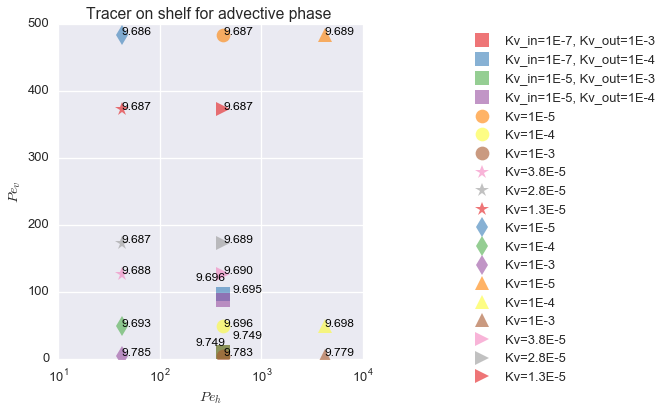

In [110]:
sns.set_palette( 'Set1',len(TrOnShList))
fig42=plt.figure(figsize=(12,6))

jj = 0

# ADVECTIVE PHASE ONLY - TIME INTEGRATED CROSS-SHELF TRANSPORT
for ii,tot,vert in zip(indexList, TrOnShList,HWCList):
    ax1 = plt.subplot(1,2,1)
    msize = (tot[18]/1.E13)+4
    plt.plot(Peh[ii] , Pev[ii],marker[jj],markersize = msize , label = labels[ii],alpha = 0.6)
    strnum = ('%1.3f' %(tot[18]/1.E13))
    if ii == 3:
        pl.text(Peh[ii]+100, Pev[ii]+10, strnum, color="black", fontsize=12)
    elif ii == 2:
        pl.text(Peh[ii]+100, Pev[ii]+20, strnum, color="black", fontsize=12)
    elif ii == 0:
        pl.text(Peh[ii]-200, Pev[ii]+10, strnum, color="black", fontsize=12)
    elif ii == 1:
        pl.text(Peh[ii]-200, Pev[ii]+20, strnum, color="black", fontsize=12)
    else:
        pl.text(Peh[ii], Pev[ii], strnum, color="black", fontsize=12)

    plt.ylabel('$Pe_v$')
    plt.xlabel('$Pe_h$')
    plt.title('Tracer on shelf for advective phase ')
    ax1.set_xscale("log", nonposy='clip')
    jj = jj+1
    
    
ax1.legend(loc ='upper right', bbox_to_anchor=(2,1))

#ax2.legend(loc =0)
plt.show()

/Users/Karina/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


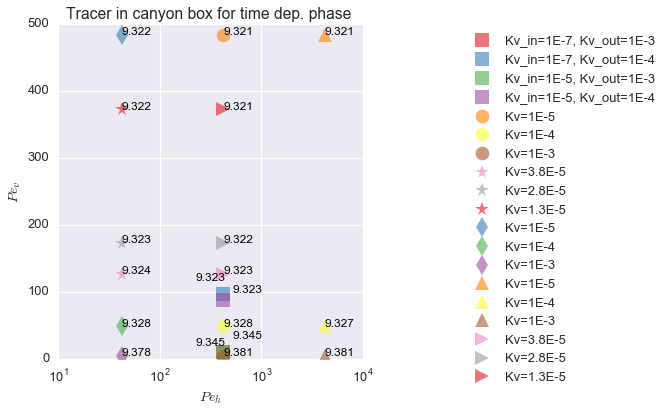

In [111]:
sns.set_palette( 'Set1',len(TrOnShList))
fig42=plt.figure(figsize=(12,6))

jj = 0

# ADVECTIVE PHASE ONLY - TIME INTEGRATED CROSS-SHELF TRANSPORT
for ii,tot,vert in zip(indexList, TrOnShList,HWCList):
    ax1 = plt.subplot(1,2,1)
    msize = (tot[18]/1.E13)+4
    plt.plot(Peh[ii] , Pev[ii],marker[jj],markersize = msize , label = labels[ii],alpha = 0.6)
    strnum = ('%1.3f' %(np.mean(tot[:10])/1.E13))
    if ii == 3:
        pl.text(Peh[ii]+100, Pev[ii]+10, strnum, color="black", fontsize=12)
    elif ii == 2:
        pl.text(Peh[ii]+100, Pev[ii]+20, strnum, color="black", fontsize=12)
    elif ii == 0:
        pl.text(Peh[ii]-200, Pev[ii]+10, strnum, color="black", fontsize=12)
    elif ii == 1:
        pl.text(Peh[ii]-200, Pev[ii]+20, strnum, color="black", fontsize=12)
    else:
        pl.text(Peh[ii], Pev[ii], strnum, color="black", fontsize=12)

    plt.ylabel('$Pe_v$')
    plt.xlabel('$Pe_h$')
    plt.title('Tracer in canyon box for time dep. phase ')
    ax1.set_xscale("log", nonposy='clip')
    jj = jj+1
    
    
ax1.legend(loc ='upper right', bbox_to_anchor=(2,1))

#ax2.legend(loc =0)
plt.show()

/Users/Karina/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


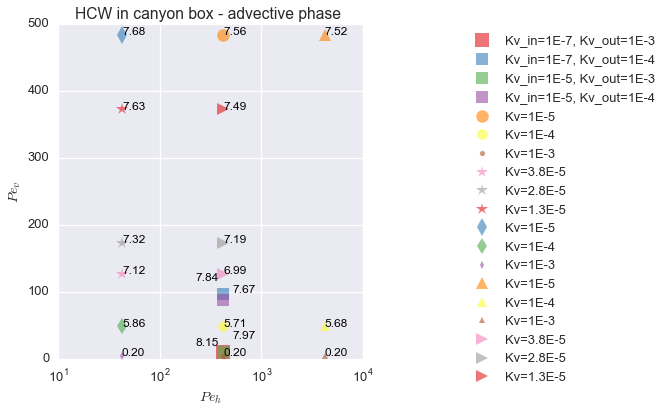

In [112]:
sns.set_palette( 'Set1',len(TrOnShList))
fig42=plt.figure(figsize=(12,6))

jj = 0

# ADVECTIVE PHASE ONLY - TIME INTEGRATED CROSS-SHELF TRANSPORT
for ii,tot,vert in zip(indexList, TrOnShList,HWCList):
    ax1 = plt.subplot(1,2,1)
    msize = (np.nanmean(vert[10:])/1.E9)+5
    plt.plot(Peh[ii], Pev[ii],marker[jj],markersize = msize , label = labels[ii],alpha = 0.6)
    
    strnum = ('%1.2f' %(np.nanmean(vert[10:])/1.E9))
    if ii == 3:
        pl.text(Peh[ii]+100, Pev[ii]+10, strnum, color="black", fontsize=12)
    elif ii == 2:
        pl.text(Peh[ii]+100, Pev[ii]+20, strnum, color="black", fontsize=12)
    elif ii == 0:
        pl.text(Peh[ii]-200, Pev[ii]+10, strnum, color="black", fontsize=12)
    elif ii == 1:
        pl.text(Peh[ii]-200, Pev[ii]+20, strnum, color="black", fontsize=12)
    else:
        pl.text(Peh[ii], Pev[ii], strnum, color="black", fontsize=12)

    plt.ylabel('$Pe_v$')
    plt.xlabel('$Pe_h$')
    plt.title('HCW in canyon box - advective phase ')
    ax1.set_xscale("log", nonposy='clip')
    jj = jj+1
    
    
ax1.legend(loc ='upper right', bbox_to_anchor=(2,1))

#ax2.legend(loc =0)
plt.show()

/Users/Karina/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


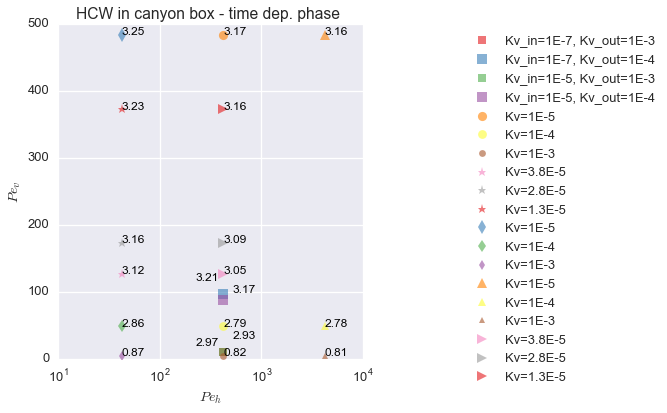

In [113]:
sns.set_palette( 'Set1',len(TrOnShList))
fig42=plt.figure(figsize=(12,6))

jj = 0

# ADVECTIVE PHASE ONLY - TIME INTEGRATED CROSS-SHELF TRANSPORT
for ii,tot,vert in zip(indexList, TrOnShList,HWCList):
    ax1 = plt.subplot(1,2,1)
    msize = (np.nanmean(vert[:10])/1.E9)+6
    plt.plot(Peh[ii], Pev[ii],marker[jj],markersize = msize , label = labels[ii],alpha = 0.6)
    
    strnum = ('%1.2f' %(np.nanmean(vert[:10])/1.E9))
    if ii == 3:
        pl.text(Peh[ii]+100, Pev[ii]+10, strnum, color="black", fontsize=12)
    elif ii == 2:
        pl.text(Peh[ii]+100, Pev[ii]+20, strnum, color="black", fontsize=12)
    elif ii == 0:
        pl.text(Peh[ii]-200, Pev[ii]+10, strnum, color="black", fontsize=12)
    elif ii == 1:
        pl.text(Peh[ii]-200, Pev[ii]+20, strnum, color="black", fontsize=12)
    else:
        pl.text(Peh[ii], Pev[ii], strnum, color="black", fontsize=12)

    plt.ylabel('$Pe_v$')
    plt.xlabel('$Pe_h$')
    plt.title('HCW in canyon box - time dep. phase ')
    ax1.set_xscale("log", nonposy='clip')
    jj = jj+1
    
    
ax1.legend(loc ='upper right', bbox_to_anchor=(2,1))

#ax2.legend(loc =0)
plt.show()